#Benchmarking Performance and Scaling of Python Clustering Algorithms

There are a host of different clustering algorithms and implementations thereof for Python. The performance and scaling can depend as much on the implementation as the underlying algorithm. Obviously a well written implementation in C or C++ will beat a naive implementation on pure Python, but there is more to it than just that. The internals and data structures used can have a large impact on performance, and can even significanty change asymptotic performance. All of this means that, given some amount of data that you want to cluster your options as to algorithm and implementation maybe significantly constrained. I'm both lazy, and prefer empirical results for this sort of thing, so rather than analyzing the implementations and deriving asymptotic performance numbers for various implementations I'm just going to run everything and see what happens.

To begin with we need to get together all the clustering implementations, along with some plotting libraries so we can see what is going on once we've got data. Obviously this is not an exhaustive collection of clustering implementations, so if I've left off your favourite I apologise, but one has to draw a line somewhere.

The implementations being test are:

* [Sklearn](http://scikit-learn.org/stable/modules/clustering.html) (which implements several algorithms):
 * K-Means clustering
 * DBSCAN clustering
 * Agglomerative clustering
 * Spectral clustering
 * Affinity Propagation
* [Scipy](http://docs.scipy.org/doc/scipy/reference/cluster.html) (which provides basic algorithms):
 * K-Means clustering
 * Agglomerative clustering
* [Fastcluster](http://danifold.net/fastcluster.html) (which provides very fast agglomerative clustering in C++)
* [DeBaCl](https://github.com/CoAxLab/DeBaCl) (Density Based Clustering; similar to a mix of DBSCAN and Agglomerative)
* [HDBSCAN](https://github.com/lmcinnes/hdbscan) (A robust hierarchical version of DBSCAN)

Obviously a major factor in performance will be the algorithm itself. Some algorithms are simply slower -- often, but not always, because they are doing more work to provide a better clustering.

In [76]:
import hdbscan
import debacl
import fastcluster
import sklearn.cluster
import scipy.cluster
import sklearn.datasets
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_palette('Paired', 10)
sns.set_color_codes()

Now we need some benchmarking code at various dataset sizes. Because some clustering algorithms have performance that can vary quite a lot depending on the exact nature of the dataset we'll also need to run several times on randomly generated datasets of each size so as to get a better idea of the average case performance.

We also need to generalise over algorithms which don't necessarily all have the same API. We can resolve that by takig a clustering function, argument tuple and keywords dictionary to let us do semi-arbitrary calls (fortunately all the algorithms do at least take the dataset to cluster as the first parameter).

Finally some algorithms scale poorly, and I don't want to spend forever doing clustering of random datasets so we'll cap the maximum time an algorithm can use; once it has taken longer than max time we'll just abort there and leave the remaining entries in our datasize by samples matrix unfilled.

In the end this all amounts to a fairly straightforward set of nested loops (over datasizes and number of samples) with calls to sklearn to generate mock data and the clustering function inside some a timer. Add in some early abort and we're done.

In [18]:
def benchmark_algorithm(dataset_sizes, cluster_function, function_args, function_kwds,
                        dataset_dimension=10, dataset_n_clusters=10, max_time=60, sample_size=8):
    
    # Initialize the result with NaNs so that any unfilled entries 
    # will be considered NULL when we convert to a pandas dataframe at the end
    result = np.nan * np.ones((len(dataset_sizes), sample_size))
    for index, size in enumerate(dataset_sizes):
        for s in range(sample_size):
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            data, labels = sklearn.datasets.make_blobs(n_samples=size, 
                                                       n_features=dataset_dimension, 
                                                       centers=dataset_n_clusters)
            
            # Start the clustering with a timer
            start_time = time.time()
            cluster_function(data, *function_args, **function_kwds)
            time_taken = time.time() - start_time
            
            # If we are taking more than max_time then abort -- we don't
            # want to spend excessive time on slow algorithms
            if time_taken > max_time:
                result[index, s] = time_taken
                return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size), 
                                               result.flatten()]).T, columns=['x','y'])
            else:
                result[index, s] = time_taken
        
    # Return the result as a dataframe for easier handling with seaborn afterwards
    return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size), 
                                   result.flatten()]).T, columns=['x','y'])

## Comparison of all ten implementations

Now we need a range of dataset sizes to test out our algorithm. Since the scaling performance is wildly different over the ten implementations we're going to look at it will be beneficial to have a number of very small dataset sizes, and increasing spacing as we get larger, spanning out to 32000 datapoints to cluster (to begin with). Numpy provides convenient ways to get this done via `arange` and vector multiplication. We'll start with step sizes of 500, then shift to steps of 1000 past 2000 datapoints, and finally steps of 2000 past 6000 datapoints.

In [19]:
dataset_sizes = np.hstack([np.arange(1, 4) * 500, np.arange(2,7) * 1000, np.arange(4,17) * 2000])

Now it is just a matter of running all the clustering algorithms via our becnhmark function for collect up all the requsite data. This could be prettier, rolled up into functions appropriately, but sometimes brute force is good enough. More importantly (for me) since this can take a significant amount of compute time, I wanted to be able to comment out algorithms that were slow or I was uninterested in easily. Which brings me to a warning for you the reader and potential user of the notebook: this next step is very expensive. We are running ten different clustering algorithms eight times each on twenty one different dataset sizes -- and some of the clustering algorithms are slow (we are capping out at a minute per run). That means that the next cell can take an hour or more to run. That doesn't mean "Don't try this at home" (I anctually encourage you to try this out yourself and play with dataset parameters and clustering parameters) but it does mean you should be patient if you're going to!

In [64]:
k_means = sklearn.cluster.KMeans(10)
k_means_data = benchmark_algorithm(dataset_sizes, k_means.fit, (), {})

dbscan = sklearn.cluster.DBSCAN()
dbscan_data = benchmark_algorithm(dataset_sizes, dbscan.fit, (), {})

fastclust_data = benchmark_algorithm(dataset_sizes, fastcluster.single, (), {})

hdbscan_ = hdbscan.HDBSCAN()
hdbscan_data = benchmark_algorithm(dataset_sizes, hdbscan_.fit, (), {})

debacl_data = benchmark_algorithm(dataset_sizes, debacl.geom_tree.geomTree, (5, 5), {'verbose':False})

agglomerative = sklearn.cluster.AgglomerativeClustering(10)
agg_data = benchmark_algorithm(dataset_sizes, agglomerative.fit, (), {})

spectral = sklearn.cluster.SpectralClustering(10)
spectral_data = benchmark_algorithm(dataset_sizes, spectral.fit, (), {})

affinity_prop = sklearn.cluster.AffinityPropagation()
ap_data = benchmark_algorithm(dataset_sizes, affinity_prop.fit, (), {})

scipy_k_means_data = benchmark_algorithm(dataset_sizes, scipy.cluster.vq.kmeans, (10,), {})

scipy_single_data = benchmark_algorithm(dataset_sizes, scipy.cluster.hierarchy.single, (), {})

Now we need to plot the results so we can see what is going on. The catch is that we have several datapoints for each dataset size and ultimately we would like to try and fit a curve through all of it to get the general scaling trend. Fortunately [seaborn](http://stanford.edu/~mwaskom/software/seaborn/) comes to the rescue here by providing `regplot` which plots a regression through a dataset, supports higher order regression (we should probably use order two as most algorithms are effectively quadratic) and handles multiple datapoints for each x-value cleanly (using the `x_estimator` keyword to put a point at the mean and draw an error bar to cover the range of data). Once again we'll just use a bit of brute-force/copy-paste to plot all ten datasets.

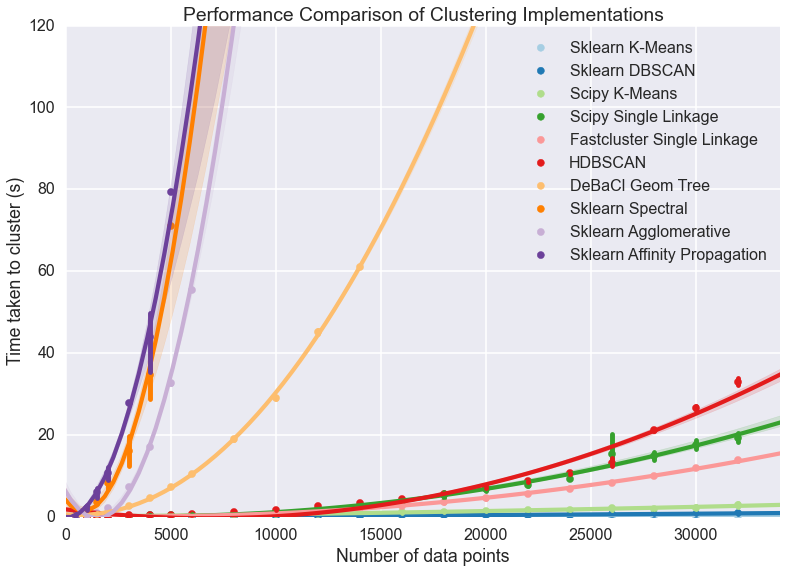

In [77]:
sns.regplot(x='x', y='y', data=k_means_data, order=2, label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=dbscan_data, order=2, label='Sklearn DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=scipy_k_means_data, order=2, label='Scipy K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=scipy_single_data, order=2, label='Scipy Single Linkage', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=fastclust_data, order=2, label='Fastcluster Single Linkage', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=hdbscan_data, order=2, label='HDBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=debacl_data, order=2, label='DeBaCl Geom Tree', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=spectral_data, order=2, label='Sklearn Spectral', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=agg_data, order=2, label='Sklearn Agglomerative', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=ap_data, order=2, label='Sklearn Affinity Propagation', x_estimator=np.mean)
plt.gca().axis([0, 34000, 0, 120])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Clustering Implementations')
plt.legend()

A few features stand out. First of all there appear to be essentially two classes of implementation, with DeBaCl being an odd case that falls in the middle. The fast implementations tend to be implementations of single linkage agglomerative clustering, K-means, and DBSCAN. The slow cases are largely from sklearn and include agglomerative clustering (in this case using Ward instead of single linkage).

For practical purposes this means that if you have much more than 10000 datapoints your clustering options are significantly constrained: sklearn spectral, agglomerative and affinity propagation are going to take far too long. DeBaCl may still be an option, but given that the hdbscan library provides "robust single linkage clustering" equivalent to what DeBaCl is doing (and with effectively the same runtime as hdbscan as it is a subset of that algorithm) it is probably not the best choice for large dataset sizes.

So let's drop out those slow algorithms so we can scale out a little further and get a closer look at the various algorithms that managed 32000 points in under thirty seconds. We may discover there is more detail to be seen among that range of algorithms.

## Comparison of fast implementations

Let's compare the six fastest implementations now. We can scale out a little further as well. Since several of the algorithms compute the (compressed) pairwise distance matrix, I am a little constrained by the amount of RAM on my laptop -- anything beyond about 40000 points fills the RAM just for the distance computation and runtimes explode due to swapping, no longer giving representative performance. On machines with enough RAM the scaling curve continues out as expected -- if you have enough RAM on your machine and wish to see this in action by all means stretch out the `large_dataset_sizes` to range up to 60000 datapoints or more.

In [ ]:
large_dataset_sizes = np.arange(1,11) * 4000

hdbscan_ = hdbscan.HDBSCAN()
large_hdbscan_data = benchmark_algorithm(large_dataset_sizes, hdbscan_.fit, (), {}, max_time=180, sample_size=5)

k_means = sklearn.cluster.KMeans(10)
large_k_means_data = benchmark_algorithm(large_dataset_sizes, k_means.fit, (), {}, max_time=180, sample_size=5)

dbscan = sklearn.cluster.DBSCAN()
large_dbscan_data = benchmark_algorithm(large_dataset_sizes, dbscan.fit, (), {}, max_time=180, sample_size=5)

large_fastclust_data = benchmark_algorithm(large_dataset_sizes, fastcluster.single, (), {}, max_time=180, sample_size=5)

large_scipy_k_means_data = benchmark_algorithm(large_dataset_sizes, scipy.cluster.vq.kmeans, (10,), {}, max_time=180, sample_size=5)

large_scipy_single_data = benchmark_algorithm(large_dataset_sizes, scipy.cluster.hierarchy.single, (), {}, max_time=180, sample_size=5)

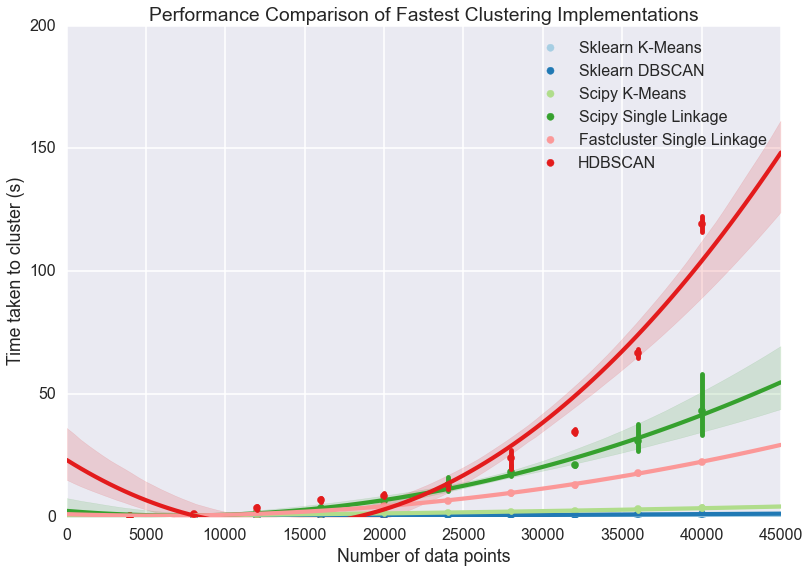

In [81]:
sns.regplot(x='x', y='y', data=large_k_means_data, order=2, label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_dbscan_data, order=2, label='Sklearn DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_scipy_k_means_data, order=2, label='Scipy K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_scipy_single_data, order=2, label='Scipy Single Linkage', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_fastclust_data, order=2, label='Fastcluster Single Linkage', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_hdbscan_data, order=2, label='HDBSCAN', x_estimator=np.mean)
plt.gca().axis([0, 45000, 0, 200])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Fastest Clustering Implementations')
plt.legend()

Now it becomes clear that there were really three classes, not two: the K-Means and DBSCAN implementations are all packed along the very bottom while HDBSCAN and the single linkage implementations begin to consume more and more time for larger datasets. There are also some quirks with the quadratic fit for HDBSCAN, but you can't have everything.

In practice this is going to mean that for larger datasets you are going to be very constrained in what algorithms you can apply: if you get enough datapoints only K-Means and DBSCAN will be left. This is somewhat disappointing, paritcularly as [K-Means is not a particularly good clustering algorithm](http://nbviewer.jupyter.org/github/lmcinnes/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb), paricularly for exploratory data analysis.

With this in mind it is worth looking at how the K-Means and DBSCAN implementations perform. If we restrict to just those algorithms we can scale out to even larger dataset sizes again, and start to see how those different algorithms and implementations separate.

## Comparison of K-Means and DBSCAN implementations

At this point we can scale out to 100000 datapoints easily enough: K-Means and DBSCAN can use various data structures to avoid having to compute the full pairwise distance matrix and are thus not as memory constrained as some of the other algorithms we looked at.

In [ ]:
huge_dataset_sizes = np.arange(1,11) * 10000

k_means = sklearn.cluster.KMeans(10)
huge_k_means_data = benchmark_algorithm(huge_dataset_sizes, k_means.fit, (), {}, max_time=120, sample_size=5)

dbscan = sklearn.cluster.DBSCAN()
huge_dbscan_data = benchmark_algorithm(huge_dataset_sizes, dbscan.fit, (), {}, max_time=120, sample_size=5)

In [71]:
huge_scipy_k_means_data = benchmark_algorithm(huge_dataset_sizes, scipy.cluster.vq.kmeans, (10,), {}, max_time=120, sample_size=5)

This time around we'll use a linear rather than quadratic fit (feel free to try the quadratic fit for yourself of course). Why is that? Because of the 'secret sauce' that keeps these implementations runtimes so low: using appropriate data structures such as kd-trees these algorithms have $O(n\log n)$ asymptotics, so while they don't actually scale linearly, a linear fit is better than a quadratic one.

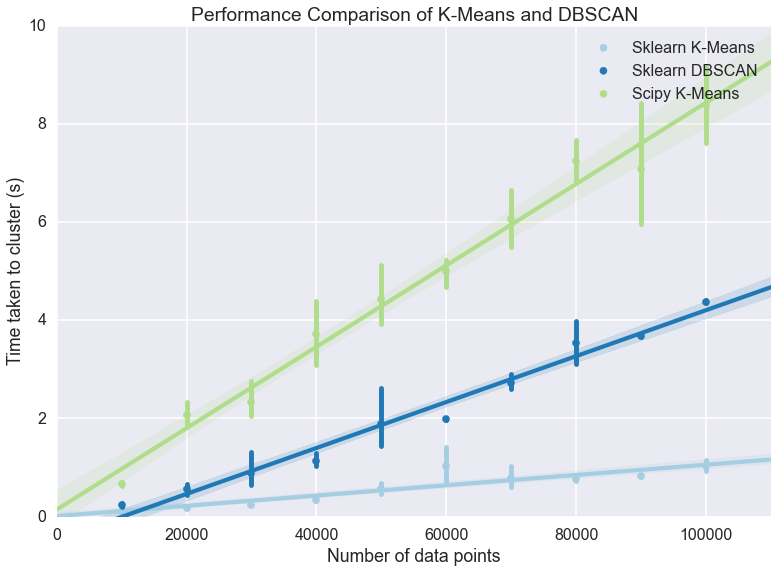

In [82]:
sns.regplot(x='x', y='y', data=huge_k_means_data, order=1, label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=huge_dbscan_data, order=1, label='Sklearn DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=huge_scipy_k_means_data, order=1, label='Scipy K-Means', x_estimator=np.mean)
plt.gca().axis([0, 110000, 0, 10])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of K-Means and DBSCAN')
plt.legend()

Now the differences become clear, and it demonstrates how much of a difference implementation can make: the sklearn implementation of K-Means is far better than the scipy implementation. The DBSCAN implementation falls somewhere in between. Since DBSCAN clustering is a lot better than K-Means (unless you have good reasons to assume that the clusters partition your data and are all drawn from Gaussian distributions) and the scaling is still very good I would suggest that unless you have a truly stupendous amount of data you wish to cluster then the sklearn DBSCAN implementation is a good choice.

## Conclusions

Performance obviously depends on the algorithm chosen, but can also vary significantly upon the specific implementation (HDBSCAN is far better hierarchical density based clustering than DeBaCl, Fastcluster is far better single linkage clustering than scipy, and sklearn has by far the best K-Means implementation). For anything beyond toy datasets, however, your algorithm options are greatly constrained. In my (obviously biased) opinion [HDBSCAN is the best algorithm for clustering](http://nbviewer.jupyter.org/github/lmcinnes/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb) that survived the first cut in our analysis, so if your data is small enough to work with that it should probably be your first option. Beyond a that the only algorithm options on the table are DBSCAN and K-Means; and obviously sklearn is the best choice there. Ultimately that really means DBSCAN should be your first option for really large datasets.

Ultimately, however, the reason K-Means and DBSCAN come out so strongly is their impressive asymptotic complexity, which win out easily even over impressively efficient implementations of other algorithms (such as fastcluster). Fortunately the [hdbscan](https://github.com/lmcinnes/hdbscan) development team has plans to bring down the asymptotics of the implementation to $O(n\log n)$, although probably with larger constants than DBSCAN and K-Means. 